# 한국 주식시장의 자본자산가격모형

자본자산가격모형(CAPM: Capital Asset Pricing Model)이란 자산, 즉 주식의 초과수익률이 기본적으로 시장 초과수익률에 비례하게 된다는 모형이다. 이 글에서는 한국 주식시장에서 자본자산가격모형이 실제로 성립하는지와 자본자산가격모형에 따른 주식 선택의 예를 살펴본다.

## 자본자산가격모형

자본자산가격모형에 의하면 시장에서 무위험이자률 $R_f$를 초과하는 주식의 수익률 $R$은 시장지수 수익률 $R_M$과 다음 식처럼 선형적인 상관관계를 가진다. 

$$ R - R_f = \alpha + \beta(R_M - R_f) + \varepsilon $$

이 식에서 베타($\beta$)는 시장 초과수익률과 자산 초과수익률의 비례상수다. 보통 자본에 대한 부채의 비율 즉, 레버리지(leverage)가 큰 종목일수록 베타가 1보다 커지고 자본 대비 부채 비율이 적은 종목일수록 베타가 1보다 작아진다. 또한 시간이 지나면서 회사의 부채비율이 안정되고 다양한 수익사업을 영유할수록 베타의 값이 1로 수렴하는 현상을 보인다고 알려져 있다. 알파($\alpha$)는 시장 대비 자산의 수익률이 더 높은 부분을 뜻하는 값으로 알파값이 클수록 시장을 뛰어넘는 좋은 수익률을 보이게 된다. 비체계적 위험 혹은 종목(회사)별 위험이라고 불리는 $\varepsilon$ 값은 시장과 관계없이 해당 종목(회사)이 가지는 고유의 위험으로 인한 수익률 변화를 말한다. 

이러한 자본자산가격모형이 실제로 한국주식시장에서 성립하는지를 살펴보기위해 5년간의 월간 수익률을 이용하여 자산 수익률과 시장 수익률의 선형회귀분석을 해본다. 수익률 데이터는 코스콤의 오픈API를 사용한다. 코스콤의 오픈API를 사용하려면 코스콤 오픈API 웹사이트에(http://devcenter.koscom.co.kr/) 회원으로 가입한 후 각각의 API에 대한 사용 계약을 체결한다. 계약 후에는 API키를 사용하여 REST API 방식으로 편리하게 데이터를 다운로드 받을 수 있다. 


In [0]:
apikey = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'  # 여기에는 실제 키값을 넣어야 한다. 

## 패키지 임포트

이 분석을 위해 우선 다음과 같은 패키지를 임포트한다. urllib, json, time 패키지는 데이터를 다운로드 받기위한 것이고 statsmodels는 회귀분석용 패키지다. numpy, scipy, pandas, matplotlib 등은 세부적인 분석을 위해 사용한다. statsmodels의 주의사항(warning)은 무시해도 된다.  

In [3]:
from urllib import request
from urllib.parse import quote_plus, urlencode
from json import loads
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import scipy as sp
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 코스피200 지수

시장 지수로는 코스피200 지수를 사용한다. 다음 API코드로 2014년 12월부터 2019년 12월까지의 5년간 월말 61개의 코스피200 지수값을 데이터프레임 형태로 다운로드 받을 수 있다. 

In [4]:
url = "https://apigw.koscom.co.kr/v2/market/index/kospi/K51/history"
queryParams = '?' + urlencode({ quote_plus('trnsmCycleTpCd') : 'M' ,quote_plus('inqStrtDd') : '20141201' ,quote_plus('inqEndDd') : '20191231' ,quote_plus('reqCnt') : '61' ,quote_plus('apikey') : apikey })
response_body = request.urlopen(url + queryParams).read()
df_kospi200 = pd.DataFrame(loads(response_body)["result"]["hisLists"]).sort_values("trdDd").reset_index(drop=True)
df_kospi200

,trdDd,trdPrc,cmpprevddTpCd,opnprc,hgprc,lwprc,accTrdvol,accTrdval,cmpprevddPrc
0,20141230,244.05,5,252.09,254.68,241.89,1232291,54330950,-9.65
1,20150130,249.88,2,243.96,252.50,239.09,1442673,64525682,5.83
2,20150227,251.46,2,249.83,253.22,246.32,1169494,53736356,1.58
3,20150331,257.28,2,253.13,260.68,250.09,1770045,80257520,5.82
4,20150430,266.42,2,256.44,275.11,254.70,2297789,101308418,9.14
...,...,...,...,...,...,...,...,...,...
56,20190830,259.00,5,264.97,267.44,250.24,1807417,66653882,-7.34
57,20190930,273.55,2,258.25,278.17,257.40,1359643,58447197,14.55
58,20191031,275.82,2,273.43,279.49,266.23,1356621,62095373,2.27
59,20191129,276.78,2,276.17,287.78,275.59,1508025,67471160,0.96


이 중 `trdPrc` 필드값이 지수값이다. 그래프로 표현하면 다음과 같다.

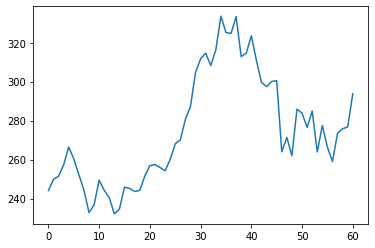

In [5]:
df_kospi200["trdPrc"].plot()
plt.show()

자본자산가격모형에 필요한 것은 가격 자체가 아닌 수익률이므로 5년간 60개의 월간 수익률을 계산하면 다음과 같다.

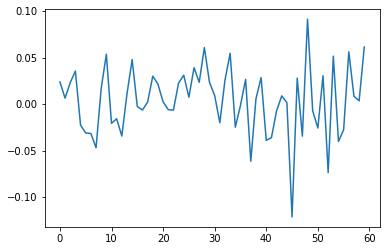

In [6]:
kospi200_rets = df_kospi200["trdPrc"].pct_change().dropna().values
plt.plot(kospi200_rets)
plt.show()

## 삼성전자

자산의 예로 삼성전자 보통주를 생각하자. 코스피200 지수와 마찬가지로 2014년 12월부터 2019년 12월까지의 주가를 다운로드 받는다.

In [7]:
url = "https://apigw.koscom.co.kr/v2/market/stocks/kospi/005930/history"
queryParams = '?' + urlencode({ quote_plus('trnsmCycleTpCd') : 'M' ,quote_plus('inqStrtDd') : '20141201' ,quote_plus('inqEndDd') : '20191231' ,quote_plus('reqCnt') : '121' ,quote_plus('apikey') : apikey  })
response_body = request.urlopen(url + queryParams).read()
df_stock = pd.DataFrame(loads(response_body)["result"]["hisLists"]).sort_values("trdDd").reset_index(drop=True)
df_stock

,trdDd,trdPrc,cmpprevddTpCd,opnprc,hgprc,lwprc,accTrdvol,accTrdval,cmpprevddPrc
0,20141230,26540,2,25880,27140,25040,5122154,6710693856326,800
1,20150130,27300,2,26800,28000,25640,5260414,7086899072535,760
2,20150227,27140,5,27300,28000,26620,3008737,4118363978978,-160
3,20150331,28820,2,27500,30200,27340,5598436,8112624535072,1680
4,20150430,28200,5,28740,29880,27180,4965983,7142279454911,-620
...,...,...,...,...,...,...,...,...,...
56,20190830,44000,5,44900,45500,42500,205260271,8996490906761,-1350
57,20190930,49050,2,44850,49650,43100,207963296,9804325904255,5050
58,20191031,50400,2,48900,52500,47350,199451656,9951418133250,1350
59,20191129,50300,5,50600,53800,50200,223956592,11676998193688,-100


월말의 가격을 시각화하면 다음과 같다. 시장 지수와 비슷한 모양을 보이는 것을 확인할 수 있다.

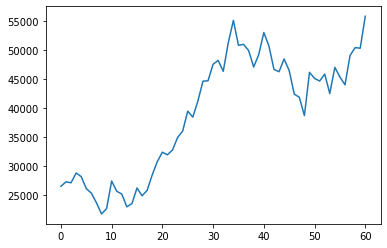

In [8]:
df_stock["trdPrc"].plot()
plt.show()

지수와 마찬가지로 60개의 월간 수익률을 계산한다. 

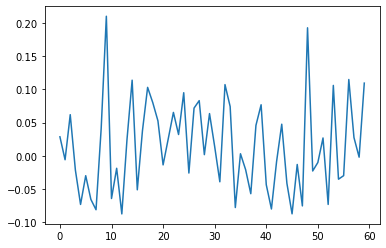

In [9]:
stock_rets = df_stock["trdPrc"].pct_change().dropna().values
plt.plot(stock_rets)
plt.show()

자본자산가격모형의 알파와 베타를 계산하기 위해 우선 지수와 주식의 수익률을 하나의 데이터프레임으로 합친다.

In [10]:
df = pd.DataFrame({"kospi200": kospi200_rets, "stock": stock_rets})
df

,kospi200,stock
0,0.023889,0.028636
1,0.006323,-0.005861
2,0.023145,0.061901
3,0.035525,-0.021513
4,-0.022633,-0.073050
5,-0.031184,-0.029839
6,-0.031593,-0.065457
7,-0.047073,-0.081013
8,0.016796,0.041322
9,0.053652,0.209877


두 수익률을 스캐터플롯(scatter plot)으로 표시하면 다음과 같이 선형적인 양의 상관관계를 가지는 것을 볼 수 있다. 

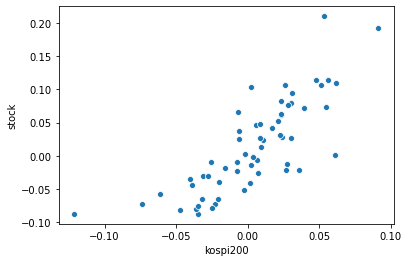

In [11]:
sns.scatterplot("kospi200", "stock", data=df)
plt.show()

### 금리

초과 수익률을 구하기 위해서는 초단기 무위험이자율 $R_f$를 알아야 한다. 여기에서는 2014년부터 2019년까지의 CD 91일 금리를 참조하여 

$$ R_f = 0.02 \;\;(2\%) $$

라고 가정한다.

In [0]:
rf = 0.02

## 알파, 베타 계산

이제 statsmodels 패키지의 OLS 명령을 사용하여 주식 초과수익률과 시장 초과수익률의 선형회귀분석을 한다.

In [13]:
model = sm.OLS.from_formula("stock - rf ~ kospi200 - rf", data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  stock   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     100.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.64e-14
Time:                        05:38:39   Log-Likelihood:                 105.97
No. Observations:                  60   AIC:                            -207.9
Df Residuals:                      58   BIC:                            -203.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0091      0.005      1.666      0.1

분석결과를 살펴보면 베타값은 1.49, 알파값은 0.01이 나오지만 유의확률(p value)를 고려하여볼 때 알파값에 대한 유의확률이 10%가 넘기 때문에 알파값은 사실상 0이라고 볼 수 있다.  

## 유가증권시장 전 종목

이번에는 유가증권시장의 모든 종목에 대해 자본자산가격모형을 적용해본다. 우선 코스콤 오픈API를 사용하여 유가증권시장의 종목 목록을 구한다. 

In [14]:
url = "https://apigw.koscom.co.kr/v2/market/stocks/kospi/lists"
queryParams = '?' + urlencode({ quote_plus('apikey') : apikey })
response_body = request.urlopen(url + queryParams).read()
df_symbols = pd.DataFrame(loads(response_body)["isuLists"])
df_symbols = df_symbols[df_symbols.isuCd.str.startswith("KR7")].reset_index(drop=True)
df_symbols

,isuSrtCd,isuCd,isuKorNm,isuKorAbbr,map_to
0,000020,KR7000020008,동화약품,동화약품,000020*001
1,000040,KR7000040006,KR모터스,KR모터스,000040*001
2,000050,KR7000050005,경방,경방,000050*001
3,000060,KR7000060004,메리츠화재,메리츠화재,000060*001
4,000070,KR7000070003,삼양홀딩스,삼양홀딩스,000070*001
...,...,...,...,...,...
1355,342600,KR7342600004,KBSTAR KRX국채선물3년10년스티프너2X,KBSTAR KRX국채선물3년10년스티프너2X,342600*001
1356,342610,KR7342610003,KBSTAR KRX국채선물3년10년플래트너,KBSTAR KRX국채선물3년10년플래트너,342610*001
1357,342620,KR7342620002,KBSTAR KRX국채선물3년10년플래트너2X,KBSTAR KRX국채선물3년10년플래트너2X,342620*001
1358,344820,KR7344820006,케이씨씨글라스,케이씨씨글라스,344820*001


이 데이터프레임의 각 행 즉, 각 종목에 대해 알파, 베타 등을 구하는 코드를 다음과 같이 함수로 구현한다.

In [0]:
def calc_beta(x):
  code = x["isuSrtCd"]
  url = "https://apigw.koscom.co.kr/v2/market/stocks/kospi/{code}/history".format(code=code)
  queryParams = '?' + urlencode({ quote_plus('trnsmCycleTpCd') : 'M' ,quote_plus('inqStrtDd') : '20141201' ,quote_plus('inqEndDd') : '20191231' ,quote_plus('reqCnt') : '61' ,quote_plus('apikey') : apikey  })
  try:
    response = request.urlopen(url + queryParams, timeout=1)
    response_body =  response.read()
    df_stock = pd.DataFrame(loads(response_body)["result"]["hisLists"]).sort_values("trdDd").reset_index(drop=True)
    stock_rets = df_stock["trdPrc"].pct_change().dropna().values
    df = pd.DataFrame({"kospi200": kospi200_rets, "stock": stock_rets})
    model = sm.OLS.from_formula("stock - rf ~ kospi200 - rf", data=df)
    result = model.fit()
    return (code, result.params["kospi200"], result.params["Intercept"], result.rsquared, result.resid.std(), result.pvalues["kospi200"], result.pvalues["Intercept"],
            2 / 3 * result.params["kospi200"] + 1 / 3)
  except Exception:
    return (code, None, None, None, None, None, None, None)

데이터프레임의 `apply` 메서드를 사용하여 전 종목에 대해 데이터를 다운로드하고 회귀분석을 실시한다.  구글 코랩을 사용하는 경우 약 15분이 걸렸다. 

In [16]:
%%time
df_beta = df_symbols.apply(calc_beta, axis=1, result_type='expand')

CPU times: user 19.5 s, sys: 805 ms, total: 20.3 s
Wall time: 17min 44s


이 방법으로 구한 각 종목의 알파와 베타의 값은 다음 데이터프레임과 같다. 데이터프레임에서 R2는 결정계수(coefficient of determination)으로 자본자산가격모형의 설명력을 뜻한다. 1에 가까울수록 설명력이 높다는 의미다. resid_sd는 비체계적 위험의 크기다. beta_p와 alpha_p는 각각 베타와 알파의 유의확률이다. 유의확률이 0에 가까울수록 진실된 값이 0이 아닐 가능성이 높아진다. adj_beta는 베이즈 추정방법에 의해 수정한 조정베타값이다.

In [17]:
df_beta = df_beta.rename(columns={0: 'isuSrtCd', 1: "beta", 2: "alpha", 3: "R2", 4: "resid_sd", 5: "beta_p", 6: "alpha_p", 7: "adj_beta"})
df_beta = df_beta.dropna().reset_index(drop=True)
df_beta

,isuSrtCd,beta,alpha,R2,resid_sd,beta_p,alpha_p,adj_beta
0,000020,0.593105,0.007834,0.069910,0.079816,4.120331e-02,0.456393,0.728737
1,000040,0.499262,-0.023518,0.025299,0.114336,2.247989e-01,0.121529,0.666175
2,000050,0.678679,-0.010811,0.099834,0.075189,1.391972e-02,0.276560,0.785786
3,000060,0.570148,0.006269,0.087167,0.068073,2.201377e-02,0.484499,0.713432
4,000070,0.147955,0.005497,0.000952,0.176878,8.150078e-01,0.813156,0.431970
...,...,...,...,...,...,...,...,...
925,210780,0.675851,0.001258,0.579811,0.021227,1.627429e-12,0.652371,0.783901
926,211210,0.637856,0.001746,0.522157,0.022513,7.117547e-11,0.555798,0.758571
927,211260,0.702900,0.000514,0.461457,0.028016,2.418720e-09,0.889064,0.801934
928,211560,0.696575,0.000789,0.446766,0.028599,5.359305e-09,0.833840,0.797717


모형의 설명력을 뜻하는 결정계수의 값을 살펴보면 
평균 결정계수의 값은 약 0.2이다. 즉, 설명력이 작기는 하지만 모형이 성립하고 있다는 것을 확인할 수 있다.

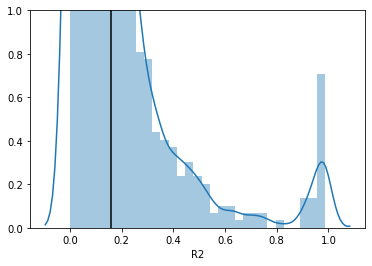

In [18]:
sns.distplot(df_beta.R2)
plt.vlines(df_beta.R2.mean(), 0, 1)
plt.ylim(0, 1)
plt.show()

베타의 값의 분포를 살펴보면 1을 중심으로 거의 대칭분포되어 있는 것을 볼 수 있다. 

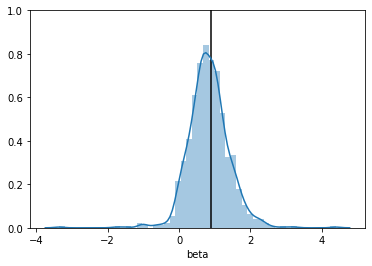

In [19]:
sns.distplot(df_beta.beta)
plt.vlines(df_beta.adj_beta.mean(), 0, 1)
plt.ylim(0, 1)
plt.show()

## 알파 주식의 검색

그러면 시장 초과수익률에 비해 종목 초과수익률이 유의하게 높은 종목을 검색해 보자. 알파의 유의확률이 1%보다 적으면서 알파값이 양수인 종목을 검색하면 다음과 같다. 

In [20]:
df_alpha = df_beta[(df_beta.alpha_p < 0.01) & (df_beta.alpha > 0)].reset_index(drop=True)
pd.merge(df_symbols, df_alpha)

,isuSrtCd,isuCd,isuKorNm,isuKorAbbr,map_to,beta,alpha,R2,resid_sd,beta_p,alpha_p,adj_beta
0,088980,KR7088980008,맥쿼리인프라,맥쿼리인프라,088980*001,0.044062,0.008951,0.004249,0.024887,6.207378e-01,7.982631e-03,0.362708
1,114100,KR7114100001,KBSTAR 국고채3년,KBSTAR 국고채3년,114100*001,-0.023129,0.001514,0.058876,0.003412,6.176233e-02,1.260245e-03,0.317914
2,114260,KR7114260003,KODEX 국고채3년,KODEX 국고채3년,114260*001,-0.022104,0.001403,0.055744,0.003356,6.934966e-02,2.277606e-03,0.318597
3,114460,KR7114460009,KINDEX 중기국고채,KINDEX 중기국고채,114460*001,-0.023162,0.001435,0.063758,0.003275,5.160578e-02,1.436120e-03,0.317892
4,114470,KR7114470008,KOSEF 국고채3년,KOSEF 국고채3년,114470*001,-0.024007,0.001488,0.063465,0.003403,5.216408e-02,1.465729e-03,0.317328
5,114820,KR7114820004,TIGER 국채3년,TIGER 국채3년,114820*001,-0.021489,0.001430,0.049717,0.003466,8.681670e-02,2.572447e-03,0.319007
6,122260,KR7122260003,KOSEF 통안채1년,KOSEF 통안채1년,122260*001,-0.005916,0.001443,0.044060,0.001017,1.074621e-01,1.442145e-15,0.329389
7,130730,KR7130730005,KOSEF 단기자금,KOSEF 단기자금,130730*001,-0.001019,0.001309,0.005513,0.000505,5.728810e-01,1.702395e-27,0.332654
8,136340,KR7136340007,KBSTAR 중기우량회사채,KBSTAR 중기우량회사채,136340*001,-0.005795,0.001594,0.002806,0.004030,6.876818e-01,3.743282e-03,0.329470
9,153130,KR7153130000,KODEX 단기채권,KODEX 단기채권,153130*001,-0.001993,0.001263,0.024706,0.000462,2.303752e-01,1.157032e-28,0.332005


대부분은 채권펀드임을 알 수 있다. 하지만 일부 종목은 채권펀드가 아니면서 양의 베타와 알파를 가지고 있다. 예를 들어 맥쿼리인프라와 KBSTAR주식혼합펀드는 주식펀드이면서 유의한 양의 알파를 가지는 것을 볼 수 있다.

In [21]:
url = "https://apigw.koscom.co.kr/v2/market/stocks/kospi/183710/history"
queryParams = '?' + urlencode({ quote_plus('trnsmCycleTpCd') : 'M' ,quote_plus('inqStrtDd') : '20141201' ,quote_plus('inqEndDd') : '20191231' ,quote_plus('reqCnt') : '121' ,quote_plus('apikey') : apikey  })
response_body = request.urlopen(url + queryParams).read()
df_stock = pd.DataFrame(loads(response_body)["result"]["hisLists"]).sort_values("trdDd").reset_index(drop=True)
df_stock

,trdDd,trdPrc,cmpprevddTpCd,opnprc,hgprc,lwprc,accTrdvol,accTrdval,cmpprevddPrc
0,20141230,27735,5,28133,28298,27292,3908,113328250,-442
1,20150130,28298,2,27700,28436,27379,4202,122439155,525
2,20150227,28408,2,28278,28499,27927,3458,101728240,119
3,20150331,28879,2,28476,29086,28308,5161,153989500,463
4,20150430,29615,2,28775,30245,28686,18552,570875920,706
...,...,...,...,...,...,...,...,...,...
56,20190830,31209,5,31672,31837,30527,4018,124172090,-645
57,20190930,32424,2,31159,32723,31114,1491,48179605,1212
58,20191031,32604,2,32400,32853,31976,7037,229708725,178
59,20191129,32703,2,32594,33525,32594,6026,199722115,100


이 중 KBSTAR 주식혼합펀드의 수익률을 지수와 비교하면 양의 알파가 존재한다는 것을 확인할 수 있다.

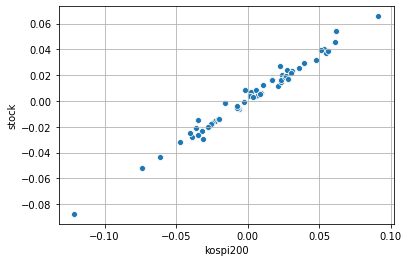

In [22]:
stock_rets = df_stock["trdPrc"].pct_change().dropna().values
df = pd.DataFrame({"kospi200": kospi200_rets, "stock": stock_rets})
sns.scatterplot("kospi200", "stock", data=df)
plt.grid(True)
plt.show()

다음 차트는 2014년 12월을 기준으로 지수와 KBSTAR 주식혼합펀드의 주가를 비교한 것이다. 베타가 0.718174로 1보다 작기 때문에 오를 때는 더 적게 오르고 내릴 때도 더 적게 내린다.

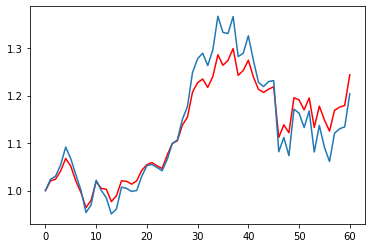

In [24]:
plt.plot(np.hstack([1, (stock_rets + 1).cumprod()]), "r")
plt.plot(np.hstack([1, (kospi200_rets + 1).cumprod()]))

알파의 존재를 확인하게 위해 베타를 1로 맞추어 비교하면 확실하게 알파가 존재함을 볼 수 있다. 


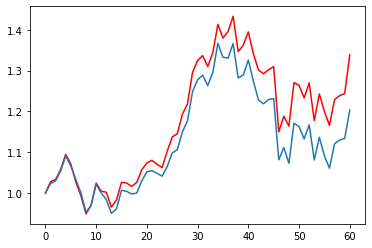

In [25]:
plt.plot(np.hstack([1, (stock_rets / 0.718174 + 1).cumprod()]), "r")
plt.plot(np.hstack([1, (kospi200_rets + 1).cumprod()]))

## 주의사항

이 글의 목적은 한국시장에서의 자본자산가격모형이 적용되는 아주 간단한 예를 보이기 위한 것으로 정밀한 분석에 기반한 것이 아니며 특정 주식을 추전하기 위한 것도 아니므로 투자의 추천에 사용될 수 없다는 점에 유의하기 바란다.